In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %% Import Libraries
from google.colab import drive

!pip install -q keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# %% Load Data

data = pd.read_csv('/content/drive/MyDrive/ML courseproject/EVChargingStationUsage.csv')

<ipython-input-24-442700d5faaa>:17: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/ML courseproject/EVChargingStationUsage.csv')


In [ ]:
data.head()

,Station Name,MAC Address,Org Name,Start Date,Start Time Zone,End Date,End Time Zone,Transaction Date (Pacific Time),Total Duration (hh:mm:ss),Charging Time (hh:mm:ss),...,Longitude,Currency,Fee,Ended By,Plug In Event Id,Driver Postal Code,User ID,County,System S/N,Model Number
0,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/29/2011 20:17,PDT,7/29/2011 23:20,PDT,7/29/2011 23:20,3:03:32,1:54:03,...,-122.160309,USD,0.0,Plug Out at Vehicle,3,95124.0,3284.0,NaN,NaN,NaN
1,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 0:00,PDT,7/30/2011 0:02,PDT,7/30/2011 0:02,0:02:06,0:01:54,...,-122.160309,USD,0.0,Customer,4,94301.0,4169.0,NaN,NaN,NaN
2,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 8:16,PDT,7/30/2011 12:34,PDT,7/30/2011 12:34,4:17:32,4:17:28,...,-122.160309,USD,0.0,Plug Out at Vehicle,5,94301.0,4169.0,NaN,NaN,NaN
3,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 14:51,PDT,7/30/2011 16:55,PDT,7/30/2011 16:55,2:03:24,2:02:58,...,-122.160309,USD,0.0,Customer,6,94302.0,2545.0,NaN,NaN,NaN
4,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 18:51,PDT,7/30/2011 20:03,PDT,7/30/2011 20:03,1:11:24,0:43:54,...,-122.160309,USD,0.0,Plug Out at Vehicle,7,94043.0,3765.0,NaN,NaN,NaN


In [ ]:
# Preprocess the data
def convert_to_seconds(time_str):
    if isinstance(time_str, str):
        h, m, s = map(int, time_str.split(':'))
        return h * 3600 + m * 60 + s
    return None

selected_columns = ['Total Duration (hh:mm:ss)', 'Charging Time (hh:mm:ss)', 'Energy (kWh)',
                    'Fee', 'Gasoline Savings (gallons)', 'GHG Savings (kg)']
data_selected = data[selected_columns]
data_selected['Total Duration (seconds)'] = data_selected['Total Duration (hh:mm:ss)'].apply(convert_to_seconds)
data_selected['Charging Time (seconds)'] = data_selected['Charging Time (hh:mm:ss)'].apply(convert_to_seconds)
data_cleaned = data_selected.drop(columns=['Total Duration (hh:mm:ss)', 'Charging Time (hh:mm:ss)']).dropna()

# %% Feature and Target Definition
X = data_cleaned[['Total Duration (seconds)', 'Charging Time (seconds)', 'Fee',
                  'Gasoline Savings (gallons)', 'GHG Savings (kg)']]
y = data_cleaned['Energy (kWh)']

X.head()


<ipython-input-26-f434d202cb38>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['Total Duration (seconds)'] = data_selected['Total Duration (hh:mm:ss)'].apply(convert_to_seconds)
<ipython-input-26-f434d202cb38>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['Charging Time (seconds)'] = data_selected['Charging Time (hh:mm:ss)'].apply(convert_to_seconds)


,Total Duration (seconds),Charging Time (seconds),Fee,Gasoline Savings (gallons),GHG Savings (kg)
0,11012,6843,0.0,0.784,2.625
1,126,114,0.0,0.013,0.045
2,15452,15448,0.0,1.876,6.280
3,7404,7378,0.0,0.899,3.007
4,4284,2634,0.0,0.246,0.822


In [ ]:
# Normalize using StandardScaler (alternative to MinMaxScaler)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
X_scaled.shape


(259415, 5)

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_train.shape

(207532, 1, 5)

In [ ]:
# %% Build the LSTM Model
model = Sequential([
    LSTM(16, activation='tanh', return_sequences=True, input_shape=(1, X_train.shape[2]),
         kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    LSTM(8, activation='tanh', return_sequences=False, kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(15, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Callbacks: Early Stopping and Learning Rate Scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 1, 16)               │           1,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 15)                  │             135 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              16 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,359 (9.21 KB)

 Trainable params: 2,359 (9.21 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=36, validation_split=0.2,
                    callbacks=[early_stopping,lr_scheduler])

# %% Evaluate the Model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test MAE: {mae}")

Epoch 1/100
4612/4612 ━━━━━━━━━━━━━━━━━━━━ 45s 7ms/step - loss: 0.3356 - mae: 0.2441 - val_loss: 0.0575 - val_mae: 0.0559 - learning_rate: 0.0010
Epoch 2/100
4612/4612 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 0.1140 - mae: 0.1645 - val_loss: 0.0483 - val_mae: 0.0868 - learning_rate: 0.0010
Epoch 3/100
4612/4612 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.1037 - mae: 0.1635 - val_loss: 0.0395 - val_mae: 0.0553 - learning_rate: 0.0010
Epoch 4/100
4612/4612 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 0.0979 - mae: 0.1641 - val_loss: 0.0335 - val_mae: 0.0568 - learning_rate: 0.0010
Epoch 5/100
4612/4612 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.0949 - mae: 0.1629 - val_loss: 0.0307 - val_mae: 0.0751 - learning_rate: 0.0010
Epoch 6/100
4612/4612 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.0919 - mae: 0.1624 - val_loss: 0.0285 - val_mae: 0.0662 - learning_rate: 0.0010
Epoch 7/100
4612/4612 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - loss: 0.0922 - mae: 0.1635 - val_loss: 0.0277 - val_mae: 0.0569 - 

In [ ]:
# Predictions and inverse scaling
y_pred = model.predict(X_test)
y_pred_actual = scaler_y.inverse_transform(y_pred)
y_test_actual = scaler_y.inverse_transform(y_test)

# %% Performance Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2 = r2_score(y_test_actual, y_pred_actual)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

1622/1622 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Mean Absolute Error (MAE): 0.37
Root Mean Square Error (RMSE): 0.57
R-squared (R2): 0.99


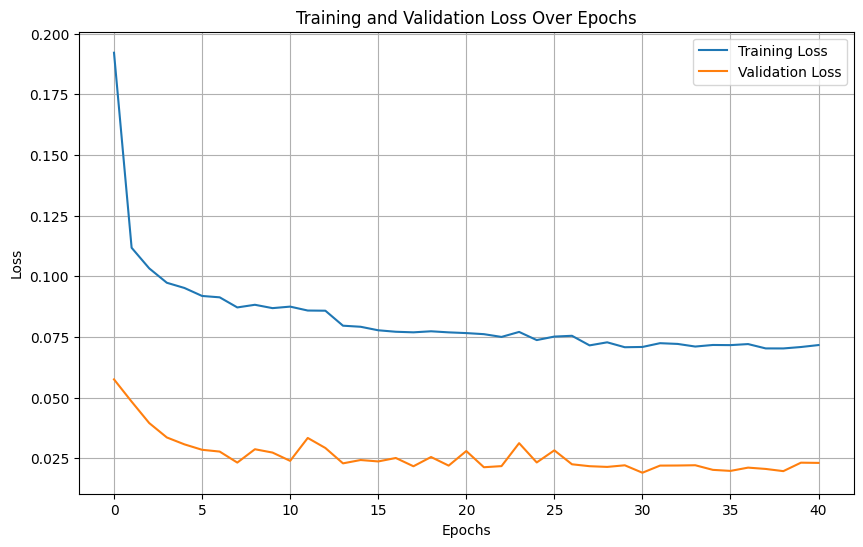

In [ ]:
# %% Visualizations
# Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

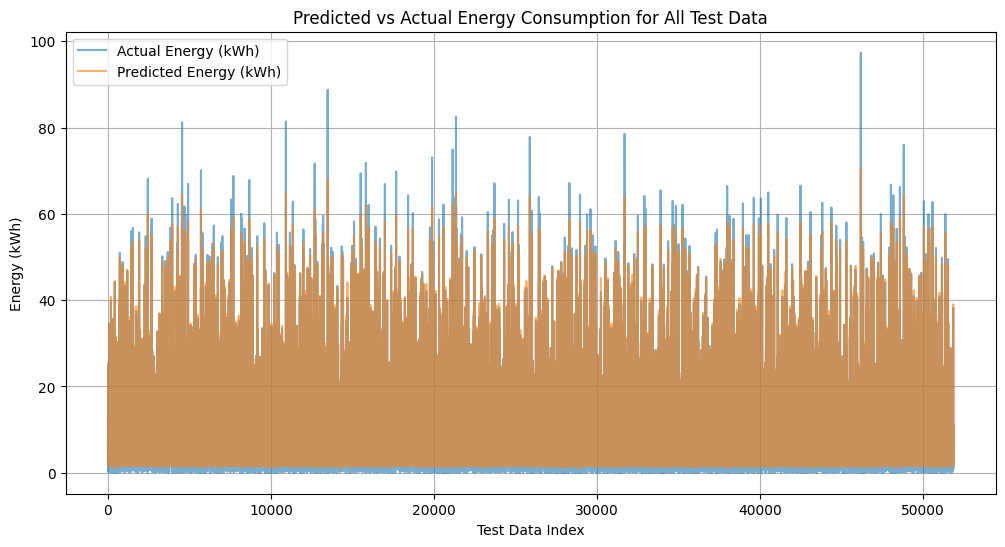

In [ ]:
# Actual vs Predicted for All Test Data
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Energy (kWh)", alpha=0.6)
plt.plot(y_pred_actual, label="Predicted Energy (kWh)", alpha=0.6)
plt.title("Predicted vs Actual Energy Consumption for All Test Data")
plt.xlabel("Test Data Index")
plt.ylabel("Energy (kWh)")
plt.legend()
plt.grid()
plt.show()

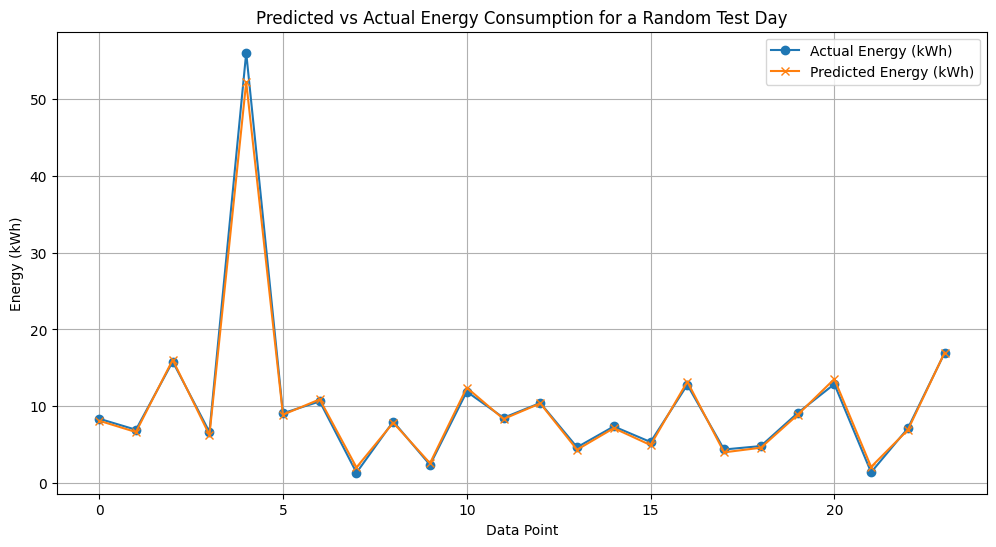

In [ ]:
# Actual vs Predicted for a Random Day
random_day_index = np.random.choice(len(y_test_actual) // 24) * 24
y_test_day = y_test_actual[random_day_index:random_day_index + 24]
y_pred_day = y_pred_actual[random_day_index:random_day_index + 24]

plt.figure(figsize=(12, 6))
plt.plot(range(24), y_test_day, label="Actual Energy (kWh)", marker='o')
plt.plot(range(24), y_pred_day, label="Predicted Energy (kWh)", marker='x')
plt.title("Predicted vs Actual Energy Consumption for a Random Test Day")
plt.xlabel("Data Point")
plt.ylabel("Energy (kWh)")
plt.legend()
plt.grid()
plt.show()

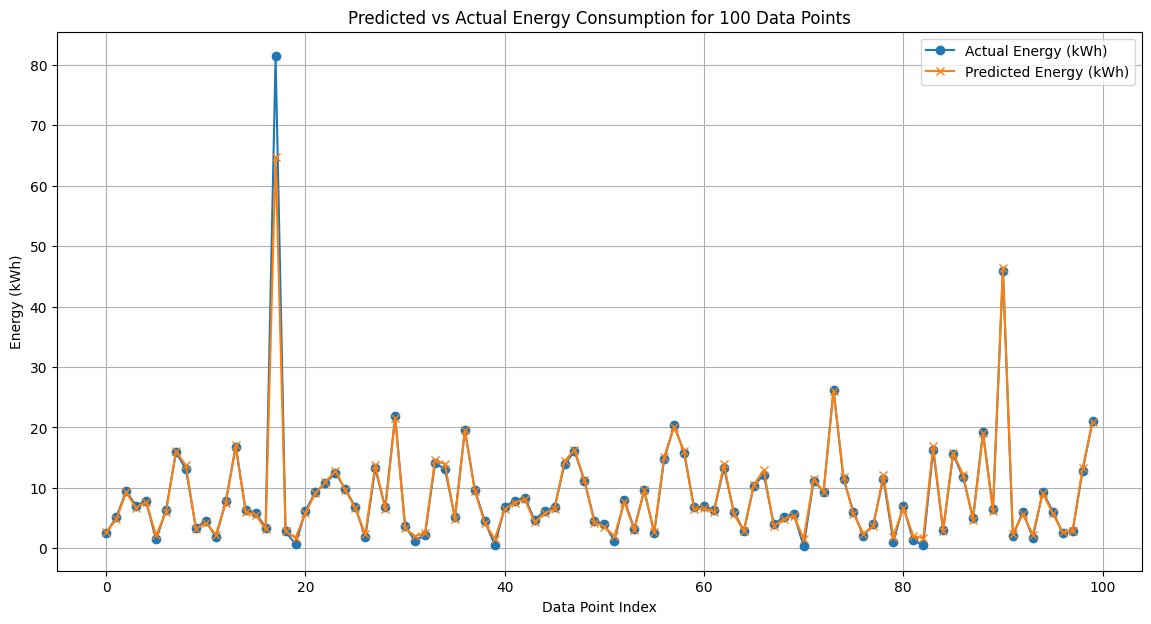

In [ ]:
# Actual vs Predicted for a Random Segment of 100 Data Points
random_segment_index = np.random.choice(len(y_test_actual) - 100)  # Ensure a valid range for 50 points
y_test_segment = y_test_actual[random_segment_index:random_segment_index + 100]
y_pred_segment = y_pred_actual[random_segment_index:random_segment_index + 100]

plt.figure(figsize=(14, 7))
plt.plot(range(100), y_test_segment, label="Actual Energy (kWh)", marker='o')
plt.plot(range(100), y_pred_segment, label="Predicted Energy (kWh)", marker='x')
plt.title("Predicted vs Actual Energy Consumption for 100 Data Points")
plt.xlabel("Data Point Index")
plt.ylabel("Energy (kWh)")
plt.legend()
plt.grid()
plt.show()
